In [1]:
# add path (for local)
import sys
repo_root = "../"
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

In [2]:
%load_ext autoreload
%autoreload 2

from rdkit import RDLogger
from utils import conf_from_yaml, generator_from_conf
RDLogger.DisableLog('rdApp.*') # use debug: true to log invalid mols

def generate_and_analyze(generator, conf):
    generator.generate(time_limit=conf.get("time_limit"), max_generations=conf.get("max_generations"))
    generator.plot(**conf.get("plot_args", {}))
    generator.analyze()

def queue_generations(*args: str):
    for yaml_path in args:
        conf = conf_from_yaml(yaml_path, repo_root)
        generator = generator_from_conf(conf, repo_root)
        generate_and_analyze(generator, conf)

<frozen importlib._bootstrap>:241: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterHierarchyMatcher> already registered; second conversion method ignored.
/opt/anaconda3/envs/v3-forge/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


seed: 1752557193
Starting generation...
<Best reward updated> 1 - time: 0.12, reward: 0.0000, node: Nc1nc(C(=O)F)nc([C@H](O)c2csc3ncncc23)n1
<Best reward updated> 8 - time: 0.45, reward: 0.5510, node: Nc1nc(O)nc([C@H](O)c2csc3ncncc23)n1
<Best reward updated> 42 - time: 0.82, reward: 0.5525, node: Nc1nc(CCO)nc([C@H](O)c2csc3ncncc23)n1
<Best reward updated> 89 - time: 1.34, reward: 0.5635, node: Nc1nc(CO)nc([C@H](O)c2csc3ncncc23)n1
100 - time: 1.47, average over 100: 0.0482
200 - time: 3.21, average over 100: 0.0899
300 - time: 4.35, average over 100: 0.3281
<Best reward updated> 324 - time: 4.62, reward: 0.5658, node: Nc1nc(CO)nc([C@H](F)c2csc3ncncc23)n1
<Best reward updated> 341 - time: 4.81, reward: 0.5930, node: Nc1nc(CCl)nc([C@H](O)c2csc3ncncc23)n1
400 - time: 5.62, average over 100: 0.2917
500 - time: 7.10, average over 100: 0.3140
600 - time: 9.46, average over 100: 0.2589
700 - time: 10.77, average over 100: 0.3153
800 - time: 13.00, average over 100: 0.3266
900 - time: 15.35, av

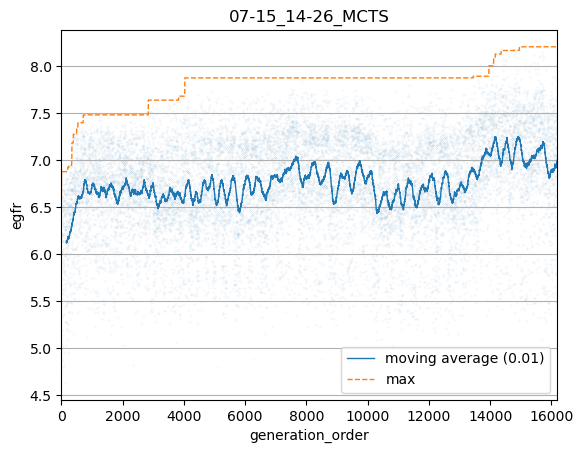

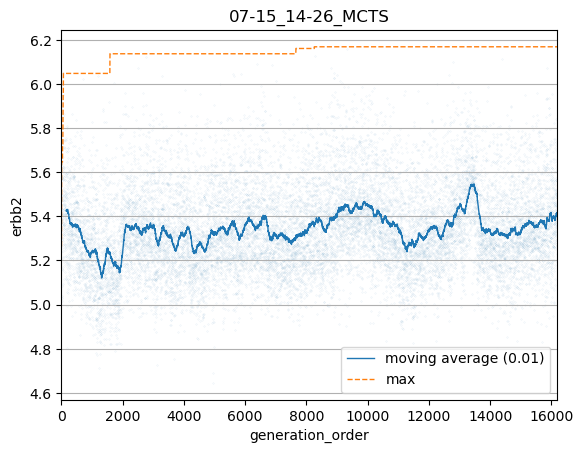

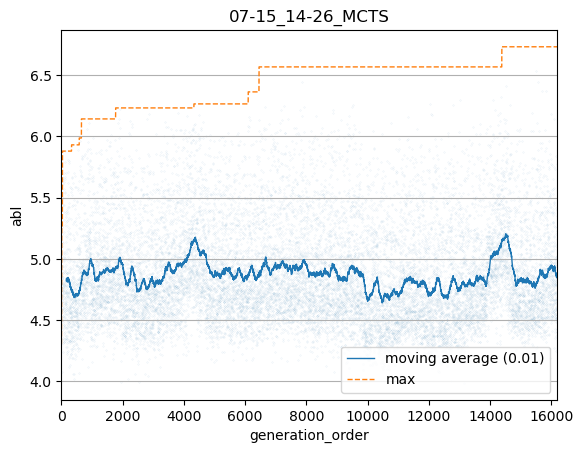

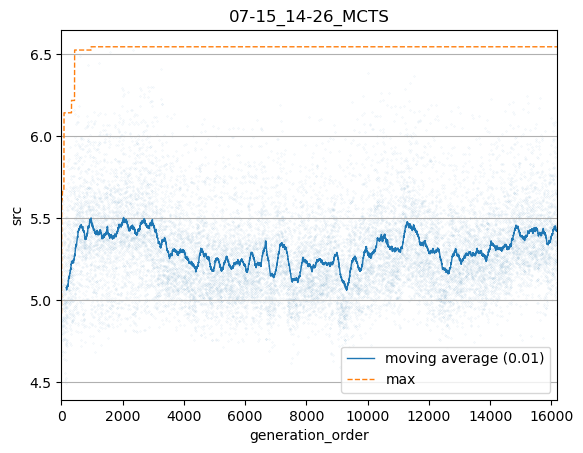

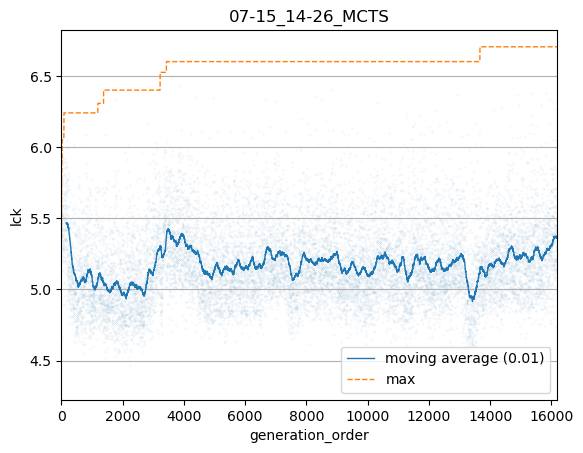

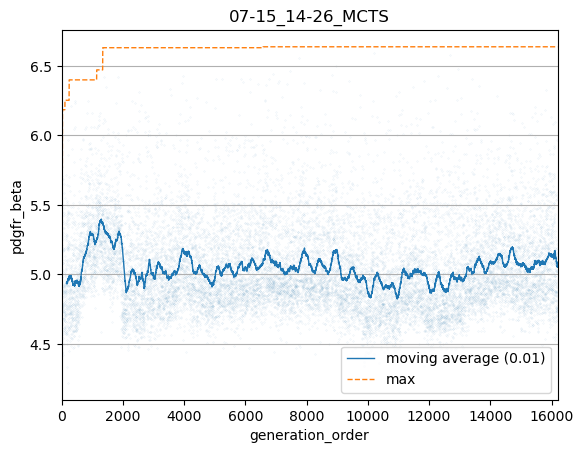

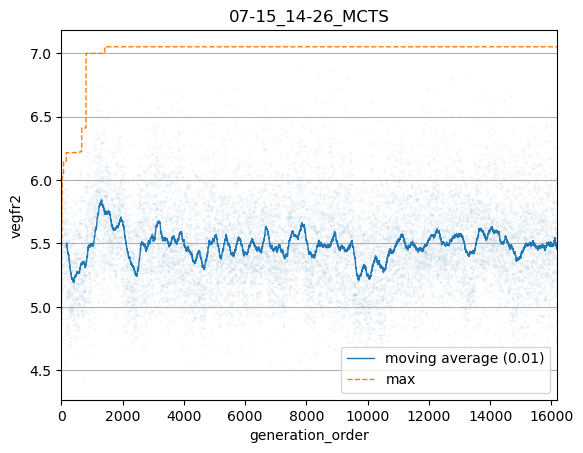

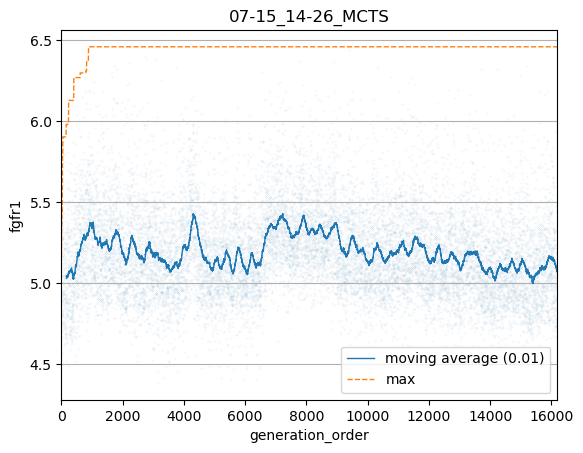

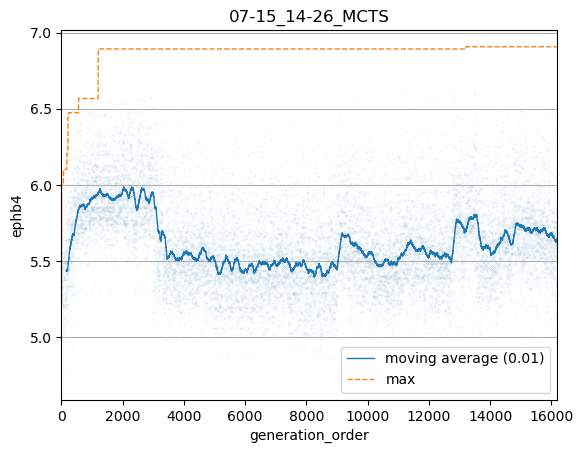

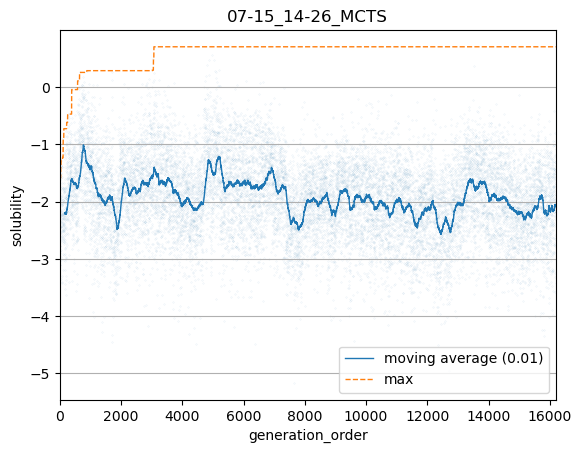

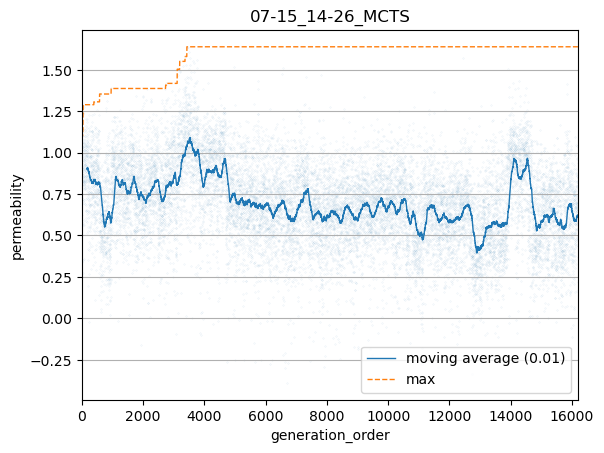

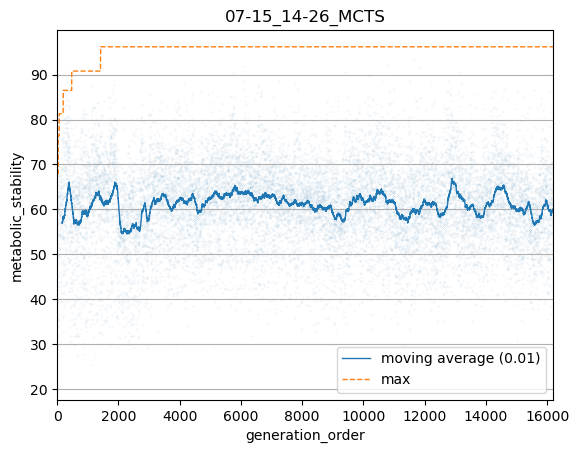

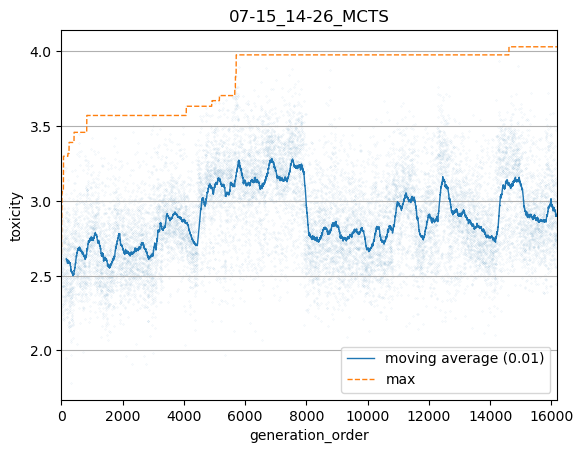

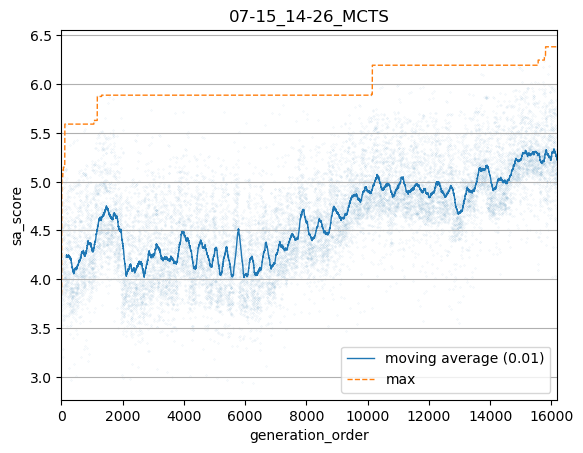

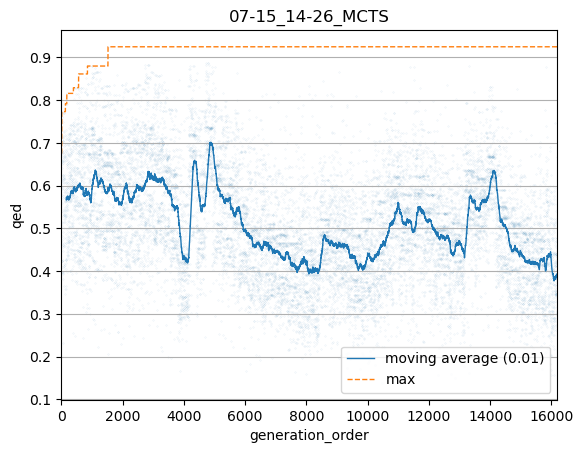

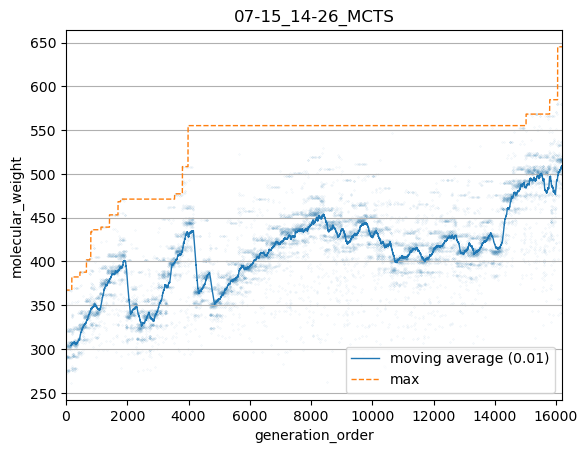

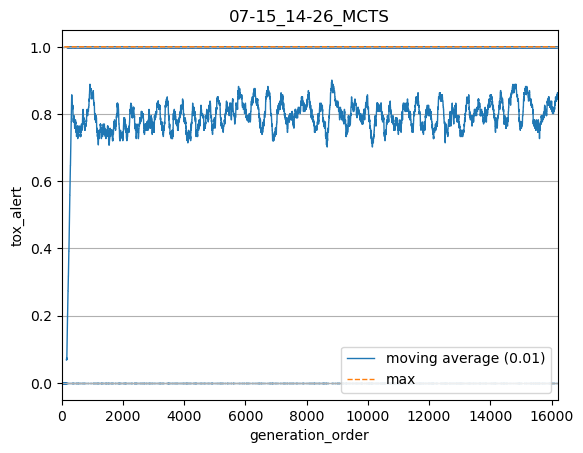

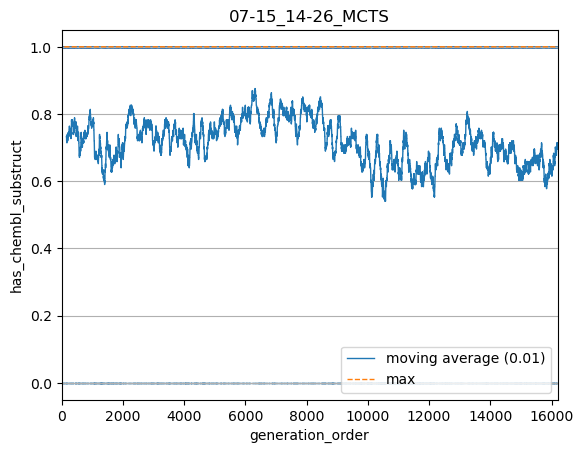

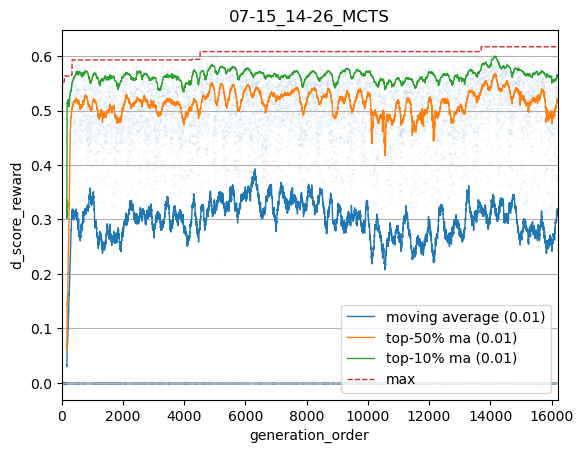

number of generated nodes: 16194
valid rate: 0.7977339901477832
unique rate: 1.0
node_per_sec: 32.55171200616237
best_reward: 0.6172337151826756
average_reward: 0.298927955309763


In [3]:
# start generation

# yaml_path = "config/mcts_helm.yaml"
# yaml_path = "config/mcts_smiles.yaml"
# yaml_path = "config/model_test.yaml"
# yaml_path = "config/mcts_d_score.yaml"
# yaml_path = "config/mcts_biot5.yaml"
yaml_path = "config/mcts_smirks.yaml"
# yaml_path = "config/mcts_jensen.yaml"
# yaml_path = "config/heapq_smiles.yaml"

conf = conf_from_yaml(yaml_path, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
# queue_generations(c1, c2)

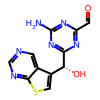

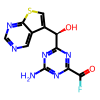

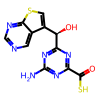

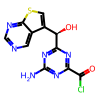

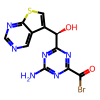

In [4]:
from utils import draw_mol
for c in generator.root.children:
    draw_mol(c.mol(), 100, 100)

In [ ]:
# continue generation
generator.generate(time_limit=conf.get("time_limit") - generator.passed_time, max_generations=conf.get("max_generations") - len(generator.unique_keys))
generator.plot(**conf.get("plot_args", {}))
generator.analyze()

In [16]:
#save mcts
save_path = generator.output_dir() + "save.mcts"
generator.save(save_path)

In [ ]:
#load generator and yaml
from generator import Generator
load_dir = "generation_result/06-26_08-51/"
conf = conf_from_yaml("sandbox/" + load_dir + "setting.yaml", repo_root)
generator = generator_from_conf(conf, repo_root)
generator = Generator.load(load_dir + "save.mcts", generator.transition)

In [ ]:
#time test
import cProfile
import pstats

profiler = cProfile.Profile()
profiler.enable()
conf = conf_from_yaml(yaml_path, repo_root)
generator = generator_from_conf(conf, repo_root)
generate_and_analyze(generator, conf)
profiler.disable()

stats = pstats.Stats(profiler)
stats.sort_stats("cumtime").print_stats(100)